RASM / RVIC Brute Force Parameter Selection
======

# Goal:

Select the RVIC velocity and diffusion parameters that reproduce the mean monthly hydrograph for the largest river basins.

## Methodology:

### RVIC Parameter Generation Step

We begin by generating parameter files for a mesh of possible flow velocity and diffusion parameters. In this case, we begin with a template RVIC parameters configuration file, and update the velocity and flow parameters for each pair of possible parameters.

### RVIC Convolution Step

Using the RVIC parameter files generated in the previous step, we perform the RVIC convolution step.  Again, we use a template configuration file and substitute just the name of the parameter file in for each set of parameters.

### Overlap Statistic

The overlap statistic was originally introduced by Perkins et al. (2007). Here we apply this statistic to the evaluation of mean monthly hydrographs, comparing the results from each RVIC convolution with streamflow observations.

ref: http://dx.doi.org/10.1175/Jcli4253.1  

### Weighted Composite Overlap Statistic

To come up with a single statistic that summarizes the performance of each pair of RVIC parameters, we weight the overlap statistic from each individual river by the mean annual runoff volume from the observations.

### Refs:
- Obserservations: Dai et al. 2009, http://www.cgd.ucar.edu/cas/catalog/surface/dai-runoff/

### Lit review:

- Flow velocities default of 0.5 m/s: http://journals.ametsoc.org/doi/pdf/10.1175/2010JHM1212.1
- Flow velocities between 0.5 m/s and 5 m/s, diffusions between 200 and 4000 m2/s.  Lohmann Telus paper (1996): http://www.tellusa.net/index.php/tellusa/article/viewFile/12200/13973

In [1]:
%matplotlib inline

# Standard-lib stuff
import os
from collections import namedtuple, OrderedDict

# Numpy/pandas/xray
import numpy as np
import pandas as pd
import xray

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# RVIC api
from rvic.parameters import parameters, read_config
from rvic.convolution import convolution

# This is where all the input data resides
# os.environ['RVIC_TEST_DATA'] = '/Users/jhamman/Dropbox/data/RVIC_test_data'

# This is where all the data will be written (up to 10 GB)
work_root = '/raid2/jhamman/workdir/RVIC_RASM_calib/'
temp_root = '/fast/jhamman/RVIC_RASM_calib/'

# True if you want to recompute the unit hydrographs or the convolution.
rerun_rvic = True

# I ran this over multiple days so the datestamp on the RVIC parameters netCDF changed after midnight.
# This just lets me look for parameters in a date flexible way
dates = ['20160706']

/home/jhamman/anaconda/envs/rasm/lib/python3.4/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Parameter Space Mesh

`params` is a list that includes pairs of velocity and diffusion. Additional pairs of parameters can be appended to the list.

In [2]:
grid_vs = np.arange(0.20, 1.51, 0.1)
grid_ds = np.arange(500, 4001, 500)
v, d = np.meshgrid(grid_vs, grid_ds)
params = list(zip(v.flatten(), d.flatten()))
params.append((2., 2000.)) # original parameters
len(params)

113

## Generate the RVIC parameters (unit hydrographs)

Loop over the list of `params` defined in the previous steps. Save some case information for use in the convoulution step (`cases`).

In [ ]:
Case = namedtuple('Case', ('velocity', 'diffusion', 'id', 'dir'))
cases = OrderedDict()

config = read_config(
    '../data/RvicGenUH_dai2006_20150816_daily_template.cfg')

for velocity, diffusion in params:
        
    caseid = 'dai_calib_{:1.2f}_{:04.0f}'.format(velocity, diffusion)
    case_dir = os.path.join(work_root, caseid)

    config['OPTIONS']['CASEID'] = caseid
    config['OPTIONS']['CASE_DIR'] = case_dir
    config['OPTIONS']['TEMP_DIR'] = os.path.join(temp_root, caseid)
    
    config['ROUTING']['VELOCITY'] = velocity
    config['ROUTING']['DIFFUSION'] = diffusion

    cases[caseid] = Case(velocity, diffusion, caseid, case_dir)

    files = [os.path.join(case_dir, 'params',
                          '{0}.rvic.prm.wr50a.{1}.nc'.format(caseid, d)) for d in dates]
    
    # make the parameters here (only if we haven't already done this)
    if rerun_rvic and not any(map(os.path.isfile, files)):
        print(cases[caseid], flush=True)
        parameters(config, numofproc=6)

Case(velocity=0.20000000000000001, diffusion=500, id='dai_calib_0.20_0500', dir='/raid2/jhamman/workdir/RVIC_RASM_calib/dai_calib_0.20_0500')


## RVIC convolution

Run the convolution step using the parameter files defined in the previous step.

In [4]:
config = read_config(
    '/Users/jhamman/workdir/RASM_RVIC_CALIB/rvic.convolution.template.cfg')

for caseid, case in cases.items():
    
    caseid = case.id
    case_dir = case.dir

    config['HISTORY']['RVICHIST_NTAPES'] = 1  # somehow this was a list???

    config['OPTIONS']['CASEID'] = caseid
    config['OPTIONS']['CASE_DIR'] = case_dir
    
    # find the parameter file
    for date in dates:
        paramfile = os.path.join(case_dir, 'params', '{0}.rvic.prm.wr50a.{1}.nc'.format(caseid, date))
        if os.path.isfile(paramfile):
            break
        else:
            paramfile = None
    if paramfile is not None:
        config['PARAM_FILE']['FILE_NAME'] = paramfile
    else:
        raise RuntimeError('Did not find paramfile for case: {0}'.format(caseid))

    # do the convolution here
    if rerun_rvic:
        convolution(config)

In [5]:
def hydrograph_overlap(obs, mod, by='month', return_data=False):
    '''
    Calculate the overlap statistic from [Perkins et al., 2007]
    (http://dx.doi.org/10.1175/Jcli4253.1)
       
    Parameters
    ----------
    obs, mod : Pandas.Series
        Series to calculate the overlap statistic on
    by : str, function, or Pandas.Grouper
        groupby directive
    return_data : bool (default=False)
        If True, return the normalized hydrographs in addition to the overlap statistic.
        
    Returns
    -------
    overlap : float
        Overlap statistic calculated from `obs` and `mod`
    '''
    
    # groupby functions
    if by == 'month':
        by = lambda x: x.month
    elif by == 'yday':
        by = lambda x: x.timetuple().tm_yday
    
    # align the series and create a pandas.DataFrame
    obs, mod = obs.align(mod, join='outer')
    df = pd.DataFrame({'obs': obs, 'mod': mod}, copy=True)
    
    # Drop any missing values
    df.dropna(axis=0, how='any', inplace=True)
    
    # Groupby "by"
    groups = df.groupby(by=by).mean()
    
    # normalize the mean grouped hydrographs
    groups /= groups.sum()
    
    # Return the overlap statistic
    overlap_stat = np.minimum(groups['obs'], groups['mod']).sum()
    
    if return_data:
        return overlap_stat, groups
    return overlap_stat

## Bringing in the Observations

First, we read in the observations from a netCDF file.  The dates in this file are a bit weight so, for now, I've just manually overwritten the time variable.  

In [6]:
# Load in Observations from Dai and Trenberth
obs = xray.open_dataset('coastal-stns-Vol-monthly.updated-oct2007.nc', decode_times=False)
obs['time'] = pd.date_range(start='1900-01-01', end='2006-12-31', freq='MS')


The easiest way to get the streamflow from the RVIC and observation datasets is by index location.  Here, I setup a dictionary that will help us lookup the index for each of these 6 rivers.

In [7]:
RiverLookUpInds = namedtuple('RiverLookUpInds', ('obs', 'rvic'))
rivers = OrderedDict()
rivers['Ob'] = RiverLookUpInds(12, 0)
rivers['Yenisey'] = RiverLookUpInds(6, 1)
rivers['Amur'] = RiverLookUpInds(16, 2)
rivers['Lena'] = RiverLookUpInds(8, 3)
rivers['Yukon'] = RiverLookUpInds(23, 4)
rivers['Mackenzie'] = RiverLookUpInds(18, 5)


We'll need these weights later when it comes time to calculate the composite statistic.

In [8]:
weights = {}
for river, inds in rivers.items():
    weights[river] = obs['FLOW'].isel(station=inds.obs).to_series().groupby(lambda x: x.month).mean().sum()
weights = pd.Series(weights)

weights /= weights.sum()

## Reading the RVIC streamflows and calculating the overlap statistic

Now we can just loop over the RVIC history files and calculate the overlap statistic for each set of velocity and diffusion pairs for each river.  We'll calculate the composite statistic next. 

In [9]:
stats = {}
datas = {}
for caseid, case in cases.items():
    
    stats[caseid] = {}
    datas[caseid] = {}
    
    ds = xray.open_dataset(os.path.join(case.dir, 'hist',
                                    '{0}.rvic.h0a.2015-01-01.nc'.format(caseid)))
    ds = ds.resample('MS', how='mean', dim='time')
    
    ds = ds.sel(time=slice('1980-01-01', '2006-12-31'))
    
    for river, inds in rivers.items():
        stat, data = hydrograph_overlap(obs['FLOW'].isel(station=inds.obs).to_series(),
                                        ds['streamflow'].isel(outlets=inds.rvic).to_series(),
                                        return_data=True)
        stats[caseid][river] = stat
        datas[caseid][river] = data

The composite statistic is calculated next.  

In [10]:
df = pd.DataFrame(stats)
df_composite = df.multiply(weights, axis='index').sum() # this is not a series


### Plot the results

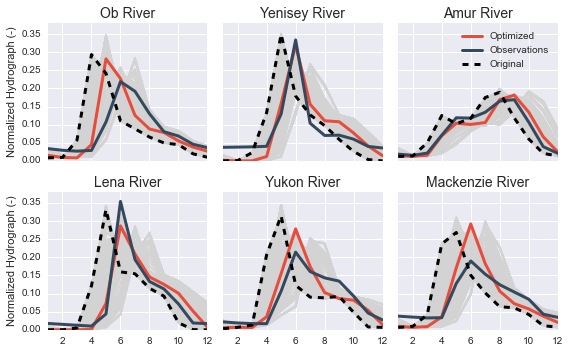

In [11]:
current_palette = sns.color_palette(["#e74c3c", "#34495e"])

case_names = df_composite.sort_values().index  # individual cases sorted by skill

fig, axes = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(8, 5))

for i, (river, data) in enumerate(rivers.items()):

    ax = axes.flat[i]
    
    if i == 2:
        legend = True
    else:
        legend = False
    
    for j, caseid in enumerate(case_names):
        datas[caseid][river]['mod'].plot(color='lightgrey', ax=ax, legend=False)
        if j == len(case_names) - 1:
            v, d = cases[caseid].velocity, cases[caseid].diffusion
            df = datas[caseid][river].rename(columns={'mod': 'Optimized', 'obs': 'Observations'})
            df.plot(ax=ax, lw=3, color=current_palette, legend=legend)
            stat_calib = stats[caseid][river]
    
    datas['dai_calib_2.00_2000'][river]['mod'].plot(color='black',
                                                    style='--',
                                                    lw=3, ax=ax,
                                                    label='Original',
                                                    legend=legend)
    stat_orig = stats['dai_calib_2.00_2000'][river]
    
    
    
#     ax.set_title('{0}: {1:1.2f} - {2:1.2f}'.format(river, stat_orig, stat_calib),
#               fontsize=14)
    ax.set_title('{0} River'.format(river), fontsize=14)
    ax.set_ylabel('Normalized Hydrograph (-)')
    ax.set_ylim([0, 0.38])
#     if i == 2:
#         leg = ax.legend(handles=ax.lines[-3:], loc=1)
    
plt.tight_layout()

Todo - 

- shade ensemble members in each plot based on skill score
- plot parameter space (contourf)

In [12]:
df_composite = df_composite.to_frame('overlap_stat')

In [13]:
df_composite.index

Index(['dai_calib_0.20_0500', 'dai_calib_0.20_1000', 'dai_calib_0.20_1500',
       'dai_calib_0.20_2000', 'dai_calib_0.20_2500', 'dai_calib_0.20_3000',
       'dai_calib_0.20_3500', 'dai_calib_0.20_4000', 'dai_calib_0.30_0500',
       'dai_calib_0.30_1000',
       ...
       'dai_calib_1.40_4000', 'dai_calib_1.50_0500', 'dai_calib_1.50_1000',
       'dai_calib_1.50_1500', 'dai_calib_1.50_2000', 'dai_calib_1.50_2500',
       'dai_calib_1.50_3000', 'dai_calib_1.50_3500', 'dai_calib_1.50_4000',
       'dai_calib_2.00_2000'],
      dtype='object', length=113)

In [14]:

velocities = np.empty(len(df_composite))
diffusions = np.empty(len(df_composite))

for i, case in enumerate(df_composite.index):
    velocities[i] = cases[case].velocity
    diffusions[i] = cases[case].diffusion
    
df_composite['velocity'] = velocities
df_composite['diffusion'] = diffusions


In [15]:
v, d = np.meshgrid(grid_vs, grid_ds)
z = np.zeros_like(v)

for inds, val in np.ndenumerate(z):
    caseid = 'dai_calib_{:1.2f}_{:04.0f}'.format(v[inds], d[inds])
    z[inds] = df_composite['overlap_stat'][caseid]


/Users/jhamman/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


/Users/jhamman/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


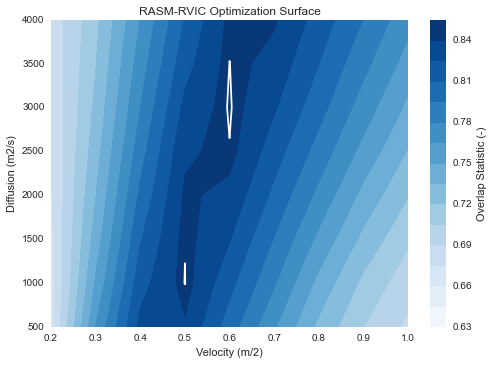

In [16]:
cmap = xray.plot.utils._load_default_cmap()
plt.contourf(v, d, z, 15, cmap='Blues')
cbar = plt.colorbar()
cbar.set_label('Overlap Statistic (-)')

plt.contour(v, d, z, levels=[0.845], c='k')

plt.xlim([0.2, 1])
plt.ylim([500, 4000])
plt.ylabel('Diffusion (m2/s)')
plt.xlabel('Velocity (m/s)')
plt.title('RASM-RVIC Optimization Surface')

In [17]:
df_composite.sort_values(by='overlap_stat')

,overlap_stat,velocity,diffusion
dai_calib_1.50_0500,0.642929,1.5,500
dai_calib_2.00_2000,0.644189,2.0,2000
dai_calib_1.40_0500,0.647038,1.4,500
dai_calib_1.50_1000,0.648296,1.5,1000
dai_calib_1.40_1000,0.653293,1.4,1000
dai_calib_1.30_0500,0.653474,1.3,500
dai_calib_1.50_1500,0.655185,1.5,1500
dai_calib_1.30_1000,0.660334,1.3,1000
dai_calib_1.40_1500,0.661440,1.4,1500
dai_calib_1.20_0500,0.662351,1.2,500


In [18]:
stat_orig = stats['dai_calib_2.00_2000']